<a href="https://colab.research.google.com/github/PoojaSaraw/ardupilot/blob/master/autonomous_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/abhinavsagar/Self-Driving-Car.git

Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 5309, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5309 (delta 16), reused 0 (delta 0), pack-reused 5282
Receiving objects: 100% (5309/5309), 85.58 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
!ls Self-Driving-Car

autonomous_car.ipynb  driving_log.csv  IMG  LICENSE  README.md	run.gif


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
## Store data
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-4-236650c5867f>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [5]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


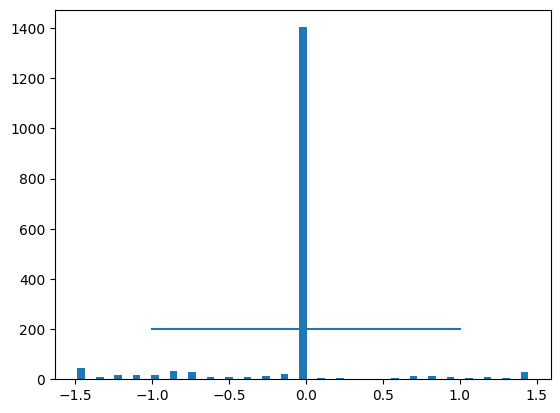

In [6]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 1743
Removed: 1203
Remaining: 540


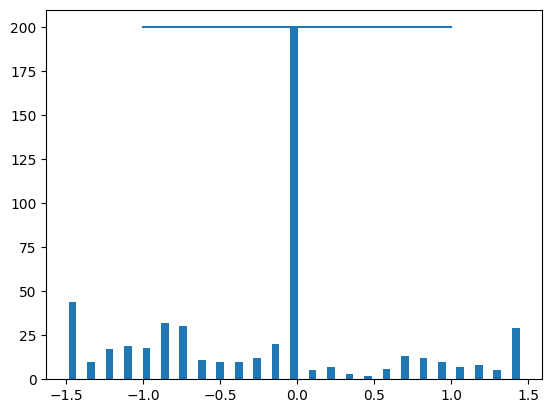

In [7]:
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 432
Valid Samples: 108


Text(0.5, 1.0, 'Validation set')

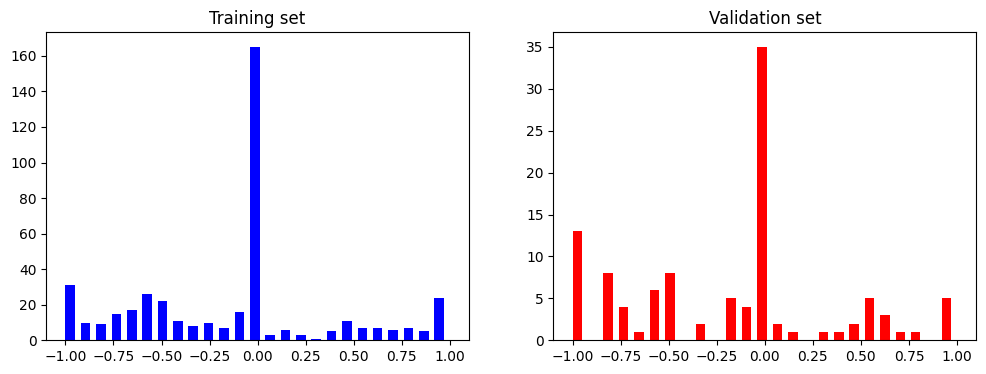

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [10]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)

  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]

  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)

  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))

  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

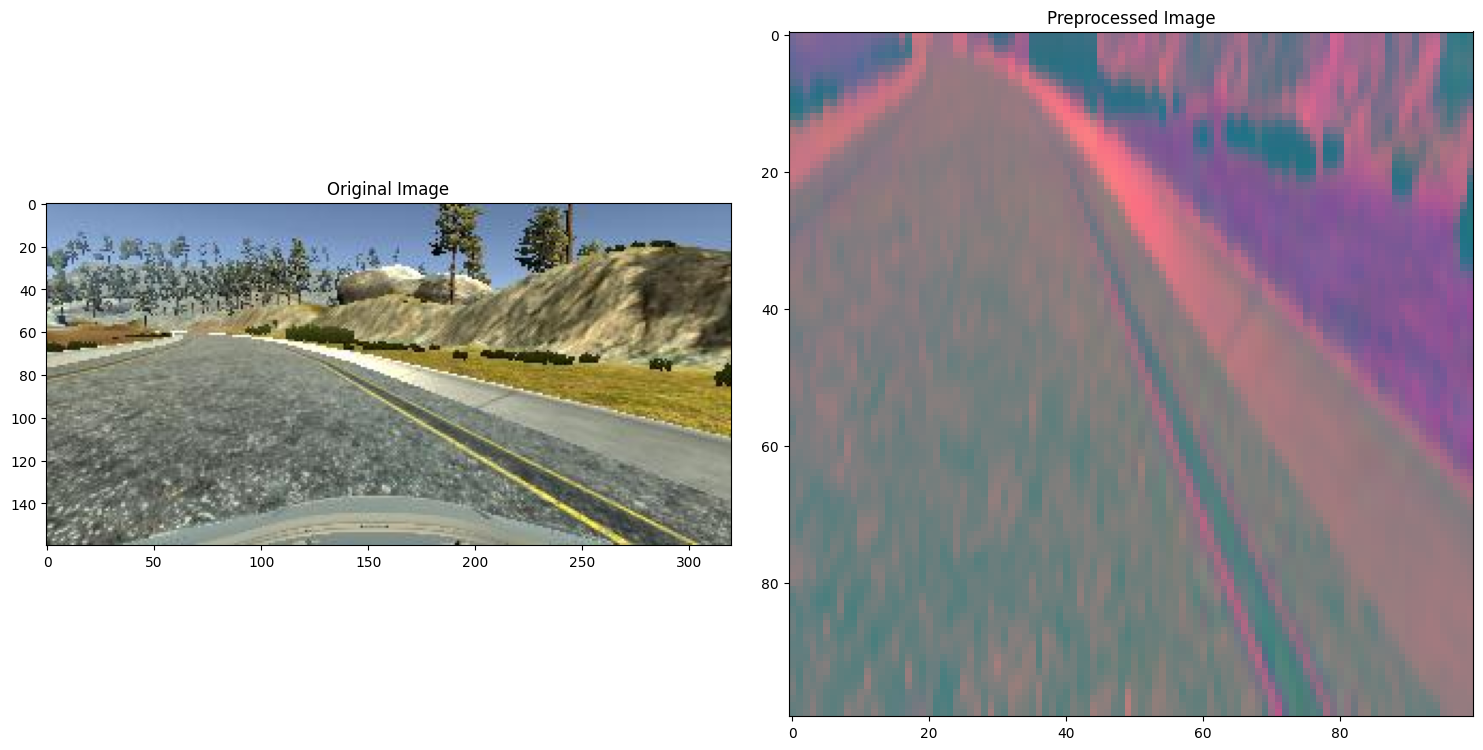

In [11]:
## Get any image
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [12]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(432, 100, 100, 3)


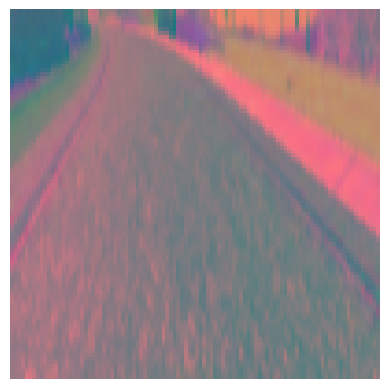

In [13]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [14]:
from keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [16]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False

for layer in resnet.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f9d1de1eda0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f9d1d6c9510> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f9d1d6c99c0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9d1d6c9e40> False
<keras.src.layers.core.activation.Activation object at 0x7f9d1d6cafb0> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f9d1d6cb340> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9d18cbc4f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f9d18cbe2f0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9d18cbcc10> False
<keras.src.layers.core.activation.Activation object at 0x7f9d18cbe5c0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f9d18cd8610> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization

In [17]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [18]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

In [19]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/25
4/4 [==============================] - 19s 1s/step - loss: 20.3891 - accuracy: 0.2593 - val_loss: 0.2906 - val_accuracy: 0.3148
Epoch 2/25
4/4 [==============================] - 0s 118ms/step - loss: 12.9559 - accuracy: 0.2616 - val_loss: 0.2875 - val_accuracy: 0.3148
Epoch 3/25
4/4 [==============================] - 0s 118ms/step - loss: 5.5983 - accuracy: 0.2546 - val_loss: 0.3021 - val_accuracy: 0.3148
Epoch 4/25
4/4 [==============================] - 1s 139ms/step - loss: 2.9241 - accuracy: 0.2801 - val_loss: 0.2873 - val_accuracy: 0.3148
Epoch 5/25
4/4 [==============================] - 0s 119ms/step - loss: 2.5950 - accuracy: 0.2755 - val_loss: 0.3901 - val_accuracy: 0.3148
Epoch 6/25
4/4 [==============================] - 1s 145ms/step - loss: 2.8314 - accuracy: 0.2500 - val_loss: 0.2870 - val_accuracy: 0.3148
Epoch 7/25
4/4 [==============================] - 1s 156ms/step - loss: 2.3728 - accuracy: 0.2361 - val_loss: 0.2883 - val_accuracy: 0.3148
Epoch 8/25
4/4 [====

Text(0.5, 0, 'Epoch')

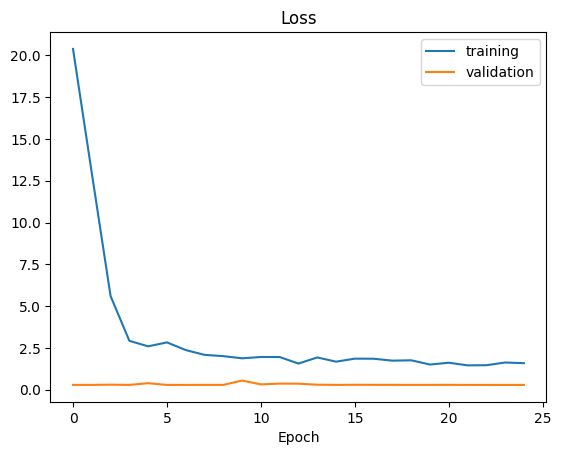

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')